## Introduction: Business Problem 


Curitiba is one of the most important cities in the southern part of Brazil. As capital of the state of Paraná, the city has more than 1,800,000 habitants and covers an area of 430.9 km². It is the 7th largest Brazilian city and 4th largest in the Southern Cone (the south part of South America). The city has the largest population and the largest economy in Southern Brazil.[5] The urban area of Curitiba is looked after by 26 local governments and has 3,335,588 people living there.


Curitiba is a city in south Brazil, capital of Paraná. It has 75 neighborhoods, divided into 9 administrative regions. The city itself has a population of 1.9 million people. It's continuously built-up urban area, is the eighth largest city in Brazil.



Curitiba is considered a leading regional city, with a strong market, culture, art, finance and education areas. Its industrial district hosts larges national and international companies, over last decades the district is continuously growing because of the city’s important role in government and commercial business.


Therefore, in this project I would like to help tourists or even residents with an analysis of the rated restaurants distribution and finally with a quick guide of the best places and region to eat for cheap in Curitiba.
Some questions we are looking to answer:


•	Which areas/neighborhoods have more restaurants in Curitiba? <br>
•	What are the best-rated restaurants to eat for cheap in Curitiba? <br>
•	Is it possible to define the best location to eat for cheap in Curitiba? <br>

Target audience:

People interested on eating well for less, tourists or residents who looks for a guide of great food for cheap. Business Analyst, who wish to analyze the neighborhoods of Curitiba using python, Jupiter notebook and some machine learning techniques.


## Data

The following data will be used for this purpose: 
<br>
-	1st Data: https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba <br> 
        The list of Curitiba neighborhoods, with area, population and average net income;
-	2nd Data: https://nominatim.openstreetmap.org/ <br>
        Coordinates from each neighborhood;
-	3rd Data: https://developer.foursquare.com/ <br>
        Restaurants lists database, containing Category, ID and coordinates;
-	4rd Data: https://developer.foursquare.com/ <br>
        Restaurants ratings, likes, tips and price;


But before dealing with the data, lets first install the necessary librariesfor this project, in case they weren't installed before:

In [ ]:
!pip install --user wikipedia
!pip install --user folium
!pip install --user geopy
!pip install --user geopandas
!pip install --user geojson
!pip install --user yellowbrick
!pip install --user pyproj


And now import them:

In [2]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# map rendering library
import folium
from folium import plugins
from folium.plugins import HeatMap

# KMeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Extras
import pickle
from functools import reduce
from pyproj import Geod

print('Libraries imported.')

Libraries imported.


The first data is a Wikipedia page about Curitiba neighborhoods. Neighborhoods are spitted into nine boroughs, each one in one table, that contains information of population, households, average income and area. We will scrape the page and create a data frame consisting of seven columns: Neighborhood, Area, Men, Women, Total, Households, Avg. Income. With the Area and Total (total population) columns we can calculate Population Density and create another column;

Now let's scrape our first data from wikipedia and parse using BeautifulSoup:

### 1st Data - Wikipedia

In [4]:
# fetching Wikipedia data
data = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba').text

In [5]:
# parsing data using BeautifulSoup
soup = BeautifulSoup(data, 'html.parser')

In [6]:
# find tables
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [ ]:
# create dataframe with Curitiba Neighborhoods

temp_content=[]

for index,table in enumerate(tables):
    if 1 < index < 11:
        temp = pd.read_html(str(table), flavor='bs4',thousands=' ')[0]
        temp = temp.drop([0,1,2])
        temp_content.append(temp)


temp_content = pd.concat(temp_content)
curitiba_df = pd.DataFrame(temp_content)
curitiba_df.reset_index(drop=True, inplace=True)
column_names = ['Neighborhood', 'Area', 'Men', 'Women', 'Total', 'Households','Avg. Income' ] 
curitiba_df.columns = column_names


In [20]:
# convert numbers stored as str

for i in range(1,7):
    curitiba_df.iloc[:,i] = curitiba_df.iloc[:,i].str.replace(',', '')
    curitiba_df.iloc[:,i] = curitiba_df.iloc[:,i].str.split(' ')
    curitiba_df.iloc[:,i] = curitiba_df.iloc[:,i].agg(lambda x: ' '.join(map(str, x)).encode('ascii', 'ignore'))
    curitiba_df.iloc[:,i] = pd.to_numeric(curitiba_df.iloc[:,i], errors='coerce')
    if i == 6 or i == 1:
        curitiba_df.iloc[:,i] = curitiba_df.iloc[:,i]/100


In [ ]:
# calculate population density

curitiba_df['Population Density'] = curitiba_df['Total']/curitiba_df['Area']

Let's take a look into our dataframe

In [16]:
curitiba_df

,Neighborhood,Area,Men,Women,Total,Households,Avg. Income,Population Density
0,Ganchinho,11.20,3667,3658,7325,1921,767.35,654.017857
1,Sitio Cercado,11.12,50631,51779,102410,27914,934.95,9209.532374
2,Umbará,22.47,7280,7315,14595,17064,908.70,649.532710
3,Abranches,4.32,5463,5702,11165,3154,1009.67,2584.490741
4,Atuba,4.27,6156,6476,12632,3627,1211.60,2958.313817
5,Bacacheri,6.98,10762,12344,23106,7107,3029.00,3310.315186
6,Bairro Alto,7.02,20244,21789,42033,12071,1211.60,5987.606838
7,Barreirinha,3.73,8079,8942,17021,5024,1272.18,4563.270777
8,Boa Vista,5.14,13677,15714,29391,9212,1817.40,5718.093385
9,Cachoeira,3.07,3811,3927,7738,2091,908.70,2520.521173


In order to save our databases into files for later use, we are going to use pickle.

https://www.synopsys.com/blogs/software-security/python-pickling/

Pickle in Python is primarily used in serializing and deserializing a Python object structure. In other words, it’s the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network. The pickled byte stream can be used to re-create the original object hierarchy by unpickling the stream. This whole process is similar to object serialization in Java or .Net.

In [154]:
# save curitiba_df to pickle

with open('curitiba_df.pkl', 'wb') as f:
        pickle.dump(curitiba_df, f)

In [3]:
# load curitiba_df from pickle

with open('curitiba_df.pkl', 'rb') as f:
        curitiba_df = pickle.load(f)

### 2st Data - Nominatim

Then, we will be using the Geocoder Nominatim python package to retrieve the Neighborhoods coordinates. This is our second database and we stored it with pickle and joined into our main curitiba_df database. 

In [69]:
# Use geopy library to get the latitude and longitude values of Curitiba Neighborhoods and create a dataframe

location = [x for x in curitiba_df['Neighborhood'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    try:
        address = location[i] + ', Curitiba, PR, Brazil'
        geolocator = Nominatim(user_agent="curitiba_dataset")
        loc = geolocator.geocode(address)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of {} are {}, {}.'.format(location[i],loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
        
# create a dataframe with the location, latitude and longitude
df_cwb_coord = pd.DataFrame({'Neighborhood':location, 
                    'Latitude': latitude,
                    'Longitude':longitude})


The geographical coordinate of Ganchinho are -25.5720763, -49.2636674.
The geographical coordinate of Sitio Cercado are -25.5427012, -49.2691056.
The geographical coordinate of Umbará are -25.5681693, -49.2856994.
The geographical coordinate of Abranches are -25.3614742, -49.272054.
The geographical coordinate of Atuba are -25.3875003, -49.2066058.
The geographical coordinate of Bacacheri are -25.3968497, -49.2344563.
The geographical coordinate of Bairro Alto are -25.4058225, -49.2076602.
The geographical coordinate of Barreirinha are -25.3685642, -49.2604545.
The geographical coordinate of Boa Vista are -25.4576591, -48.9292726.
The geographical coordinate of Cachoeira are -25.3539823, -49.2572706.
The geographical coordinate of Pilarzinho are -25.3963479, -49.2875575.
The geographical coordinate of Santa Cândida are -25.3698739, -49.2305741.
The geographical coordinate of São Lourenço are -25.3887613, -49.266281.
The geographical coordinate of Taboão are -25.3733813, -49.2807648.
Th

Let's visualize the dataframe generated:

In [63]:
df_cwb_coord

,Neighborhood,Latitude,Longitude
0,Ganchinho,-25.572076,-49.263667
1,Sitio Cercado,-25.542701,-49.269106
2,Umbará,-25.568169,-49.285699
3,Abranches,-25.361474,-49.272054
4,Atuba,-25.387500,-49.206606
5,Bacacheri,-25.396850,-49.234456
6,Bairro Alto,-25.405822,-49.207660
7,Barreirinha,-25.368564,-49.260455
8,Boa Vista,-25.388479,-49.243713
9,Cachoeira,-25.353982,-49.257271


And save it as a file:

In [64]:
# save curitiba_df to pickle

with open('df_cwb_coord.pkl', 'wb') as f:
        pickle.dump(df_cwb_coord, f)

In [17]:
# load curitiba_df from pickle

with open('df_cwb_coord.pkl', 'rb') as f:
        df_cwb_coord = pickle.load(f)

Now let's merge curitiba_df with df_cwb_coord to get the coordinates on our main neighborhood database:

In [65]:
curitiba_df_coord = curitiba_df.merge(df_cwb_coord, on='Neighborhood', how='left')

The result was a database with 76 neighborhoods and 10 columns that looks like the following:

In [66]:
curitiba_df_coord

,Neighborhood,Area,Men,Women,Total,Households,Avg. Income,Population Density,Latitude,Longitude
0,Ganchinho,11.20,3667,3658,7325,1921,767.35,654.017857,-25.572076,-49.263667
1,Sitio Cercado,11.12,50631,51779,102410,27914,934.95,9209.532374,-25.542701,-49.269106
2,Umbará,22.47,7280,7315,14595,17064,908.70,649.532710,-25.568169,-49.285699
3,Abranches,4.32,5463,5702,11165,3154,1009.67,2584.490741,-25.361474,-49.272054
4,Atuba,4.27,6156,6476,12632,3627,1211.60,2958.313817,-25.387500,-49.206606
5,Bacacheri,6.98,10762,12344,23106,7107,3029.00,3310.315186,-25.396850,-49.234456
6,Bairro Alto,7.02,20244,21789,42033,12071,1211.60,5987.606838,-25.405822,-49.207660
7,Barreirinha,3.73,8079,8942,17021,5024,1272.18,4563.270777,-25.368564,-49.260455
8,Boa Vista,5.14,13677,15714,29391,9212,1817.40,5718.093385,-25.388479,-49.243713
9,Cachoeira,3.07,3811,3927,7738,2091,908.70,2520.521173,-25.353982,-49.257271


Finally we can save this neighborhood data base into a file with Pickle:

In [67]:
# save curitiba_df_coord to pickle

with open('curitiba_df_coord.pkl', 'wb') as f:
        pickle.dump(curitiba_df_coord, f)


In [4]:
# load curitiba_df_coord from pickle
     
with open('curitiba_df_coord.pkl', 'rb') as f:
        curitiba_df_coord = pickle.load(f)


#### Let's visualize the data we have so far: 

Curitiba neighborhood centers:

In [5]:
map_curitiba = folium.Map(location=[curitiba_df_coord['Latitude'][0], curitiba_df_coord['Longitude'][0]], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(curitiba_df_coord['Latitude'], 
                                           curitiba_df_coord['Longitude'],  
                                           curitiba_df_coord['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_curitiba)  
    
map_curitiba

And to start understanding how the population is distributted:

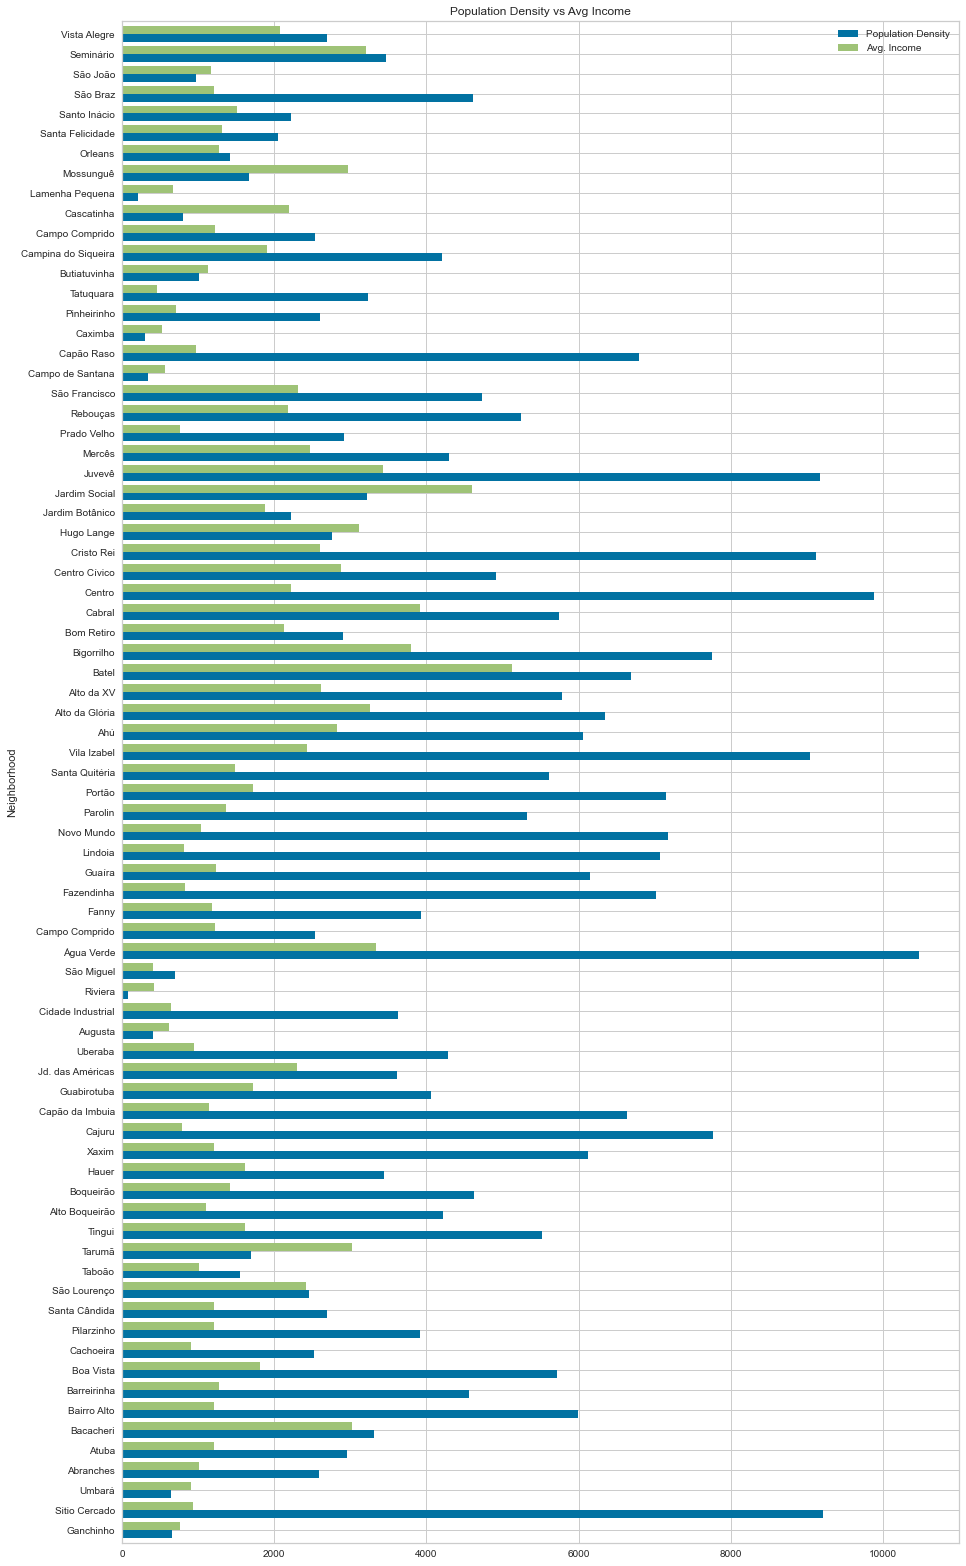

In [29]:
# plot data


curitiba_df_coord[['Population Density', 'Avg. Income']].plot(kind='barh', figsize=(15, 28), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Population Density vs Avg Income') # add title to the plot
plt.yticks (np.arange(len(curitiba_df_coord)), curitiba_df_coord['Neighborhood'])
plt.show()

### 3st Data - Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.


Foursquare credentials are defined in hidden cell bellow.

In [ ]:
## Define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20210330'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Define function to get nearby restaurants

In [10]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]
        
        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['id'],
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

Curitiba Restaurants within a 1000m radius from neighborhood coordinates:

In [11]:
curitiba_restaurants_1000 = getNearbyRestaurants(names=curitiba_df_coord['Neighborhood'],
                                         latitudes=curitiba_df_coord['Latitude'],
                                         longitudes=curitiba_df_coord['Longitude'],
                                         radius=1000)

Let's see how it looks:

In [39]:
curitiba_restaurants_1000.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Dist
0,Abranches,-25.361474,-49.272054,Panificadora E Confeitaria Espírito Santo,-25.356506,-49.273200,595aa015f427de4e1b4455b6,Bakery,562.326643
1,Abranches,-25.361474,-49.272054,D1a Lanches,-25.363250,-49.262613,50f806d4e4b0ee633fd5a9b7,Hot Dog Joint,970.404256
2,Abranches,-25.361474,-49.272054,Casa de Carnes Quality,-25.365375,-49.271793,60439b4df488de20aaef1843,Steakhouse,432.945883
3,Abranches,-25.361474,-49.272054,Famas Beer,-25.366502,-49.275230,525b4e3d11d2cf380c35e70f,Pizza Place,642.130764
4,Abranches,-25.361474,-49.272054,Panificadora E Confeitaria Hayama,-25.369311,-49.268146,4dbd83c30437955ec04dfeda,Bakery,953.130906
5,Ahú,-25.399841,-49.261943,Batataria Curitiba,-25.402340,-49.260083,537fe797498e22b2a67b9bb8,Restaurant,334.132788
6,Ahú,-25.399841,-49.261943,MaisQPão,-25.401814,-49.261891,4da8c39d8154abafc283a4c2,Breakfast Spot,218.604332
7,Ahú,-25.399841,-49.261943,Calenzano Pizzarias,-25.401579,-49.262915,4e18fdbde4cd49a7e3ef8203,Pizza Place,215.914581
8,Ahú,-25.399841,-49.261943,Trigo & Cia,-25.406493,-49.260479,4d6fffc1b09a8eec78e487fe,Bakery,751.437602
9,Ahú,-25.399841,-49.261943,Hotdog Mada,-25.398675,-49.256338,4e727af0aeb7cbc3bc3b014d,Food Truck,578.544226


And the size of this dataframe:

In [13]:
curitiba_restaurants_1000.shape

(3085, 8)

Considering a radius of 1000m, there may be an overlap between neighborhoods and consequently duplicated restaurants. It can be confirmed as follows:

In [14]:
print('{} uniques restaurants.'.format(len(curitiba_restaurants_1000['Venue ID'].unique())))

2369 uniques restaurants.


To deal with that, let´s consider only the closest restaurant to the neighborhood center, and drop the other. The first thing to do is calculate the distance between each restaurant and the central coordinate of the neighborhood:

In [15]:
#Function to calculate the distance between 2 coordinates

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist


In [16]:
#Apply the function to our dataframe

curitiba_restaurants_1000['Dist'] = Distance(curitiba_restaurants_1000['Neighborhood Latitude'].tolist(),
                                                 curitiba_restaurants_1000['Neighborhood Longitude'].tolist(),
                                                 curitiba_restaurants_1000['Venue Latitude'].tolist(),
                                                 curitiba_restaurants_1000['Venue Longitude'].tolist())

In [17]:
#Sort in ascending order:

curitiba_restaurants_1000.sort_values(['Dist'], ascending=[True], inplace=True)

In [18]:
#Drop duplicates keeping first entry:

curitiba_restaurants_1000 =  curitiba_restaurants_1000.drop_duplicates(subset='Venue ID', keep="first")

In [ ]:
#Sort by neighborhood again:

curitiba_restaurants_1000.sort_values(['Neighborhood'], ascending=[True], inplace=True)

Reset index after dropping the duplicates and now we can explore our final dataframe, with 2368 restaurants:

In [38]:
curitiba_restaurants_1000.reset_index(drop=True, inplace=True)

### 4st Data - Foursquare API Premium Calls

Next step is to obtain some statistics about the restaurants, to reach our final goal of this project. To do that, we will call upon Foursquare one more time, retrieving likes, rating and prices from our restaurants dataset:

In [21]:
#creating empty lists

like_list = []
tip_list = []
price_list = []
rating_list = []


In [22]:
# Define a function to parse JSON file

def json_get(dictionary, dot_path, default=None):
    path = dot_path.split('.')
    try:
        return reduce(dict.__getitem__, path, dictionary)
    except KeyError:
        return default
    except TypeError:
        return default

Our database has 2369 items, so we will split the request on 5 due to the Foursquare 500 daily API limit for premium calls.

In [40]:
# set up to pull the likes, rates and price from the API based on venue ID


url_list = []

for venue_id in list(curitiba_restaurants_1000['Venue ID'][1988:2400].tolist()):
    venue_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    url_list.append(venue_url)
    
for link in url_list:
    #print(link)
    #print(result)
    result = requests.get(link).json()
    likes = json_get(result, 'response.venue.likes.count')
    tip = json_get(result, 'response.venue.stats.tipCount')
    price = json_get(result, 'response.venue.price.tier')
    rating = json_get(result, 'response.venue.rating')  
    like_list.append(likes)
    tip_list.append(tip)
    price_list.append(price)
    rating_list.append(rating)
#nearby_venues['likes'] = like_list
#nearby_venues.head()

To avoid data loss during the five days of collections, we will save the partial results using Pickle one more time:

In [43]:
# save partial results to pickle, to continue in next day
   

with open('curitiba_restaurants_1000.pkl', 'wb') as f:
        pickle.dump(curitiba_restaurants_1000, f)
with open('like_list.pkl', 'wb') as f:
        pickle.dump(like_list, f)
with open('tip_list.pkl', 'wb') as f:       
        pickle.dump(tip_list, f)
with open('price_list.pkl', 'wb') as f:
        pickle.dump(price_list, f)
with open('rating_list.pkl', 'wb') as f:
        pickle.dump(rating_list, f)
        

In [42]:
len(like_list)

2369

In [34]:
# load from pickle

with open('curitiba_restaurants_1000.pkl', 'rb') as f:
        curitiba_restaurants_1000 = pickle.load(f)  
with open('like_list.pkl', 'rb') as f:
        like_list = pickle.load(f)
with open('tip_list.pkl', 'rb') as f:       
        tip_list = pickle.load(f)
with open('price_list.pkl', 'rb') as f:
        price_list = pickle.load(f)
with open('rating_list.pkl', 'rb') as f:
        rating_list = pickle.load(f)

Now lets join the results into our main restaurants dataframe and name it curitiba_restaurants, that is our final database to be explored.

In [ ]:
curitiba_restaurants = curitiba_restaurants_1000
curitiba_restaurants['Likes'] = like_list
curitiba_restaurants['Tips'] = tip_list
curitiba_restaurants['Price'] = price_list
curitiba_restaurants['Rating'] = rating_list

In [46]:
# save to pickle curitiba_restaurants

with open('curitiba_restaurants.pkl', 'wb') as f:
        pickle.dump(curitiba_restaurants, f)

In [7]:
# load from pickle curitiba_restaurants

with open('curitiba_restaurants.pkl', 'rb') as f:
        curitiba_restaurants = pickle.load(f)

Considering the goal of our project, only evaluated restaurants must be in our final database and after dropping rows with NaN in the columns of interest (ratings, likes, tips and price), 1268 restaurants remained for our analysis, as follows:

In [8]:
curitiba_restaurants = curitiba_restaurants.dropna()

In [9]:
curitiba_restaurants.shape

(1268, 13)

In [10]:
curitiba_restaurants.reset_index(drop=True, inplace=True)

Quickly examine the resulting dataframe.

In [11]:
curitiba_restaurants.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Dist,Likes,Tips,Price,Rating
0,Ahú,-25.399841,-49.261943,Batataria Curitiba,-25.402340,-49.260083,537fe797498e22b2a67b9bb8,Restaurant,334.132788,19,6,2.0,7.8
1,Ahú,-25.399841,-49.261943,Calenzano Pizzarias,-25.401579,-49.262915,4e18fdbde4cd49a7e3ef8203,Pizza Place,215.914581,29,10,1.0,6.0
2,Ahú,-25.399841,-49.261943,Trigo & Cia,-25.406493,-49.260479,4d6fffc1b09a8eec78e487fe,Bakery,751.437602,8,0,1.0,5.9
3,Ahú,-25.399841,-49.261943,Restaurante Chaminé,-25.402534,-49.269136,4cb48ce775ebb60cde66e3ad,Brazilian Restaurant,782.823512,49,31,2.0,6.3
4,Ahú,-25.399841,-49.261943,Albatroz,-25.401421,-49.271737,4bb8bad1314e952100af489d,Seafood Restaurant,1000.875514,104,70,3.0,5.7
5,Ahú,-25.399841,-49.261943,Subway,-25.403057,-49.258522,5436a8b2498e5eeeb333cf3b,Sandwich Place,495.349517,33,5,1.0,6.6
6,Ahú,-25.399841,-49.261943,Kenji Kaiten,-25.406707,-49.265539,513376b2e4b0826888c4d57a,Japanese Restaurant,842.271465,184,77,3.0,6.4
7,Ahú,-25.399841,-49.261943,Mannus,-25.402085,-49.258511,4c38ab711e06d13a0a21783e,Restaurant,425.476520,83,34,2.0,6.2
8,Ahú,-25.399841,-49.261943,Bar do Victor,-25.397768,-49.270446,4b9b1813f964a5202cf235e3,Seafood Restaurant,885.946457,387,128,3.0,8.0
9,Ahú,-25.399841,-49.261943,Cafe Da Ordem,-25.401961,-49.269412,4ec55cc9e5fa74ea535c3f86,Café,787.378468,5,1,1.0,6.0


## Methodology

In this project we will direct our efforts on detecting areas of Curitiba that have high restaurant density, particularly those with high number of cheap and well evaluated restaurants, resulting in an interactive map of Where to Eat Well fot Cheap in Curitiba.

In first step we have collected the required **data: location and type (category) of every restaurant within 1km from each neighborhood center**. We have also collected **Foursquarer user´s evaluations** of those restaurants (API premium calls).

Second step in our analysis will be the exploration of Curitiba, in terms of **restaurants distribution, evaluation and price statistics and top categories** per neighborhood.

In third and final step we will create cluster (using **k-means clustering**) of restaurants based on **price and rating**, identify the cluster with higher rates and lower price and focus on this list to create interactive maps with the results.


## Analysis

### Number of Restaurants per Neighborhood

Let's start exploring the neighborhoods counting the number of restaurants on each neighborhood and visualize in a graphic:

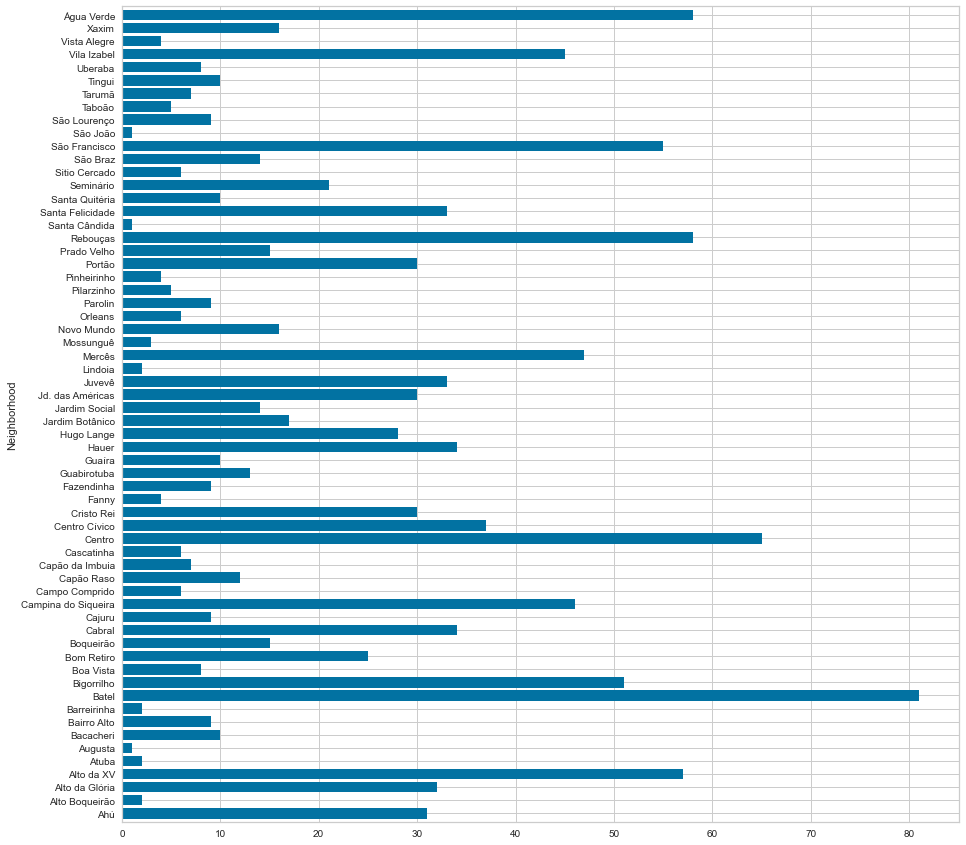

In [212]:
# Plot data

curitiba_restaurants_count = curitiba_restaurants.groupby('Neighborhood').count()
curitiba_restaurants_count['Venue'].plot(kind='barh', figsize=(15, 15), width = 0.8)
plt.show()

Another information that might be usefull for our analisys to understand the city of Curitiba, is getting the number of restaurants by Category, ranking and taking a look into the 20 most common:

In [234]:
curitiba_rest_cat_count = curitiba_restaurants.groupby(['Venue Category']).count()
curitiba_rest_cat_count.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Longitude', 'Venue','Venue ID', 'Tips', 'Venue Latitude','Dist','Likes','Price','Rating'], axis = 1, inplace = True)
curitiba_rest_cat_count.columns = ['Number of restaurants']
curitiba_rest_cat_count.sort_values(by='Number of restaurants', ascending=False, inplace=True)
curitiba_rest_cat_count.head(20)

,Number of restaurants
Venue Category,
Pizza Place,146
Brazilian Restaurant,146
Bakery,129
Restaurant,89
Italian Restaurant,88
Café,74
Burger Joint,59
Fast Food Restaurant,44
BBQ Joint,44


And some statistics grouped by Neighborhood about the likes, rating and prices obtained from Foursquare:

In [45]:
cwb_rest_neigh_stats = curitiba_restaurants.groupby('Neighborhood').agg({'Likes':'sum','Tips':'sum','Rating':'mean','Price':'mean'})
cwb_rest_neigh_stats.columns = ['Likes_Sum', 'Tips_Sum', 'Rating_Mean', 'Price_Mean']
cwb_rest_neigh_stats.sort_values(by='Likes_Sum', ascending=False, inplace=True)
cwb_rest_neigh_stats.head(20)

,Likes_Sum,Tips_Sum,Rating_Mean,Price_Mean
Neighborhood,,,,
Batel,12701,4037,7.835802,2.012346
Centro,7620,3047,7.840000,1.769231
Santa Felicidade,6431,1806,6.721212,1.848485
Cabral,5889,2057,7.017647,1.911765
Água Verde,4898,2138,7.162069,1.775862
Campina do Siqueira,4871,1432,6.578261,1.826087
Rebouças,4508,1619,6.544828,1.620690
Vila Izabel,4299,1561,7.193333,1.644444
Hugo Lange,3817,1270,7.382143,2.000000


### Neighborhood´s Top Categories

In [47]:
# one hot encoding
cwb_onehot = pd.get_dummies(curitiba_restaurants[['Venue Category']], prefix="", prefix_sep="")   # Using dummies to Encode

# add neighborhood column back to dataframe
cwb_onehot['Neighborhood'] = curitiba_restaurants['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [cwb_onehot.columns[-1]] + list(cwb_onehot.columns[:-1])
cwb_onehot = cwb_onehot[fixed_columns]

print(cwb_onehot.shape)
cwb_onehot.head()

(1268, 59)


,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Café,Chinese Restaurant,Churrascaria,Deli / Bodega,Diner,Eastern European Restaurant,Empada House,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria,Peruvian Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern Brazilian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapiocaria,Thai Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Ahú,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ahú,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ahú,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ahú,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ahú,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [48]:
cwb_grouped = cwb_onehot.groupby('Neighborhood').mean().reset_index()
cwb_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Café,Chinese Restaurant,Churrascaria,Deli / Bodega,Diner,Eastern European Restaurant,Empada House,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fondue Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria,Peruvian Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern Brazilian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapiocaria,Thai Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Ahú,0.000000,0.000000,0.000000,0.032258,0.096774,0.096774,0.000000,0.032258,0.032258,0.096774,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.161290,0.000000,0.096774,0.000000,0.032258,0.129032,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000
1,Alto Boqueirão,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alto da Glória,0.000000,0.000000,0.062500,0.000000,0.062500,0.187500,0.000000,0.000000,0.000000,0.187500,0.062500,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.031250,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.031250,0.031250,0.062500,0.031250,0.000000,0.000000,0.093750,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Alto da XV,0.000000,0.017544,0.000000,0.052632,0.070175,0.140351,0.000000,0.017544,0.017544,0.087719,0.052632,0.017544,0.035088,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.070175,0.000000,0.105263,0.000000,0.035088,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000
4,Atuba,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Augusta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.

Lets write a function to sort the venues in descending order.

In [49]:


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [51]:


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cwb_grouped['Neighborhood']

for ind in np.arange(cwb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cwb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted




,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahú,Pizza Place,Seafood Restaurant,Restaurant,Bakery,Brazilian Restaurant,Café,Italian Restaurant,Chinese Restaurant,Steakhouse,Japanese Restaurant
1,Alto Boqueirão,Bakery,American Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria,Peruvian Restaurant
2,Alto da Glória,Brazilian Restaurant,Café,Snack Place,Chinese Restaurant,Asian Restaurant,Bakery,Restaurant,Sushi Restaurant,Gastropub,Salad Place
3,Alto da XV,Brazilian Restaurant,Restaurant,Café,Pizza Place,Bakery,Italian Restaurant,Japanese Restaurant,BBQ Joint,Chinese Restaurant,Middle Eastern Restaurant
4,Atuba,Bakery,Café,American Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria
5,Augusta,Snack Place,American Restaurant,Sandwich Place,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria
6,Bacacheri,Hot Dog Joint,Bakery,Brazilian Restaurant,Pizza Place,Café,Sandwich Place,New American Restaurant,Noodle House,Seafood Restaurant,Molecular Gastronomy Restaurant
7,Bairro Alto,Pizza Place,BBQ Joint,Sandwich Place,Tapiocaria,Hot Dog Joint,Restaurant,American Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant
8,Barreirinha,Bakery,Brazilian Restaurant,American Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pastelaria
9,Batel,Italian Restaurant,Café,Pizza Place,Brazilian Restaurant,Burger Joint,Gastropub,Restaurant,French Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant


### K-Means Clustering

Let us now **cluster** those locations to create **groups of restaurants with similar prices and rating**. After defining groups, we will try to identify the group with **the best ratings and lowest prices**.

In [12]:
curitiba_rest_clustering = curitiba_restaurants.filter(['Price','Rating'])
curitiba_rest_clustering

,Price,Rating
0,2.0,7.8
1,1.0,6.0
2,1.0,5.9
3,2.0,6.3
4,3.0,5.7
5,1.0,6.6
6,3.0,6.4
7,2.0,6.2
8,3.0,8.0
9,1.0,6.0


Identity the optimal number of clusters using KElbowVisualizer

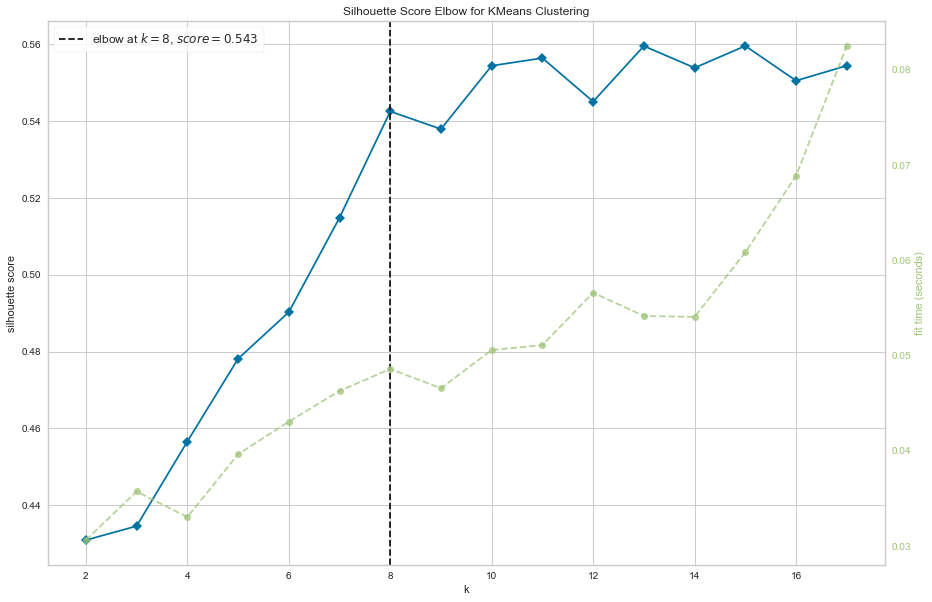

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [54]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,18), metric='silhouette', size=(1080, 720))

visualizer.fit(curitiba_rest_clustering) # Fit the data to the visualizer
visualizer.poof() # Draw/show/poof the dat'

Run k-means clustering with 8 clusters

In [13]:
# set number of clusters
kclusters = 8


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(curitiba_rest_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([4, 3, 3, ..., 5, 2, 2])

Join results with curitiba_restaurants dataframe

In [14]:
curitiba_restaurants['Cluster'] = kmeans.labels_  

Let´s maps the results:

In [16]:
map_clusters = folium.Map(location=[curitiba_restaurants['Neighborhood Latitude'][0], curitiba_restaurants['Neighborhood Longitude'][0]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(curitiba_restaurants['Venue Latitude'], curitiba_restaurants['Venue Longitude'], curitiba_restaurants['Neighborhood'], curitiba_restaurants['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The above map does not help much on for our analisys and to move on, we will identify the cluster of interest in the dataframe bellow.

In [17]:
curitiba_restaurants.head(80)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Dist,Likes,Tips,Price,Rating,Cluster
0,Ahú,-25.399841,-49.261943,Batataria Curitiba,-25.402340,-49.260083,537fe797498e22b2a67b9bb8,Restaurant,334.132788,19,6,2.0,7.8,4
1,Ahú,-25.399841,-49.261943,Calenzano Pizzarias,-25.401579,-49.262915,4e18fdbde4cd49a7e3ef8203,Pizza Place,215.914581,29,10,1.0,6.0,3
2,Ahú,-25.399841,-49.261943,Trigo & Cia,-25.406493,-49.260479,4d6fffc1b09a8eec78e487fe,Bakery,751.437602,8,0,1.0,5.9,3
3,Ahú,-25.399841,-49.261943,Restaurante Chaminé,-25.402534,-49.269136,4cb48ce775ebb60cde66e3ad,Brazilian Restaurant,782.823512,49,31,2.0,6.3,6
4,Ahú,-25.399841,-49.261943,Albatroz,-25.401421,-49.271737,4bb8bad1314e952100af489d,Seafood Restaurant,1000.875514,104,70,3.0,5.7,0
5,Ahú,-25.399841,-49.261943,Subway,-25.403057,-49.258522,5436a8b2498e5eeeb333cf3b,Sandwich Place,495.349517,33,5,1.0,6.6,5
6,Ahú,-25.399841,-49.261943,Kenji Kaiten,-25.406707,-49.265539,513376b2e4b0826888c4d57a,Japanese Restaurant,842.271465,184,77,3.0,6.4,0
7,Ahú,-25.399841,-49.261943,Mannus,-25.402085,-49.258511,4c38ab711e06d13a0a21783e,Restaurant,425.476520,83,34,2.0,6.2,6
8,Ahú,-25.399841,-49.261943,Bar do Victor,-25.397768,-49.270446,4b9b1813f964a5202cf235e3,Seafood Restaurant,885.946457,387,128,3.0,8.0,7
9,Ahú,-25.399841,-49.261943,Cafe Da Ordem,-25.401961,-49.269412,4ec55cc9e5fa74ea535c3f86,Café,787.378468,5,1,1.0,6.0,3


We have identified as cluster number 2 and created a new dataframe with only this restaurants, what we called cwb_goodandcheap_rest.

In [18]:
cluster = curitiba_restaurants['Cluster']==1
cwb_goodandcheap_rest = curitiba_restaurants[cluster]
cwb_goodandcheap_rest.reset_index(drop=True, inplace=True)
cwb_goodandcheap_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Dist,Likes,Tips,Price,Rating,Cluster
0,Ahú,-25.399841,-49.261943,Predileta,-25.397524,-49.271365,4de95d0fd4c0faa56447d910,Pizza Place,982.244146,5,6,1.0,8.3,1
1,Alto da Glória,-25.419448,-49.262149,Cantina Açores,-25.415675,-49.263331,4c545fe5fd2ea59314abff29,Portuguese Restaurant,434.549013,149,66,1.0,7.6,1
2,Alto da Glória,-25.419448,-49.262149,Red Velvet Coffee Shop,-25.426929,-49.260704,568ef6ca498e8e46ac1399c1,Café,841.430821,14,3,1.0,8.1,1
3,Alto da Glória,-25.419448,-49.262149,Hot Dog Benassi,-25.415452,-49.259837,513529fae4b06f715c605c89,Food Truck,500.022342,37,15,1.0,8.7,1
4,Alto da Glória,-25.419448,-49.262149,Casa da Coxinha,-25.427923,-49.261904,4c6c5ef7e13db60ca0e6d5b1,Snack Place,939.244236,90,33,1.0,7.6,1


### Number of Good and Cheap Restaurants per Neighborhood

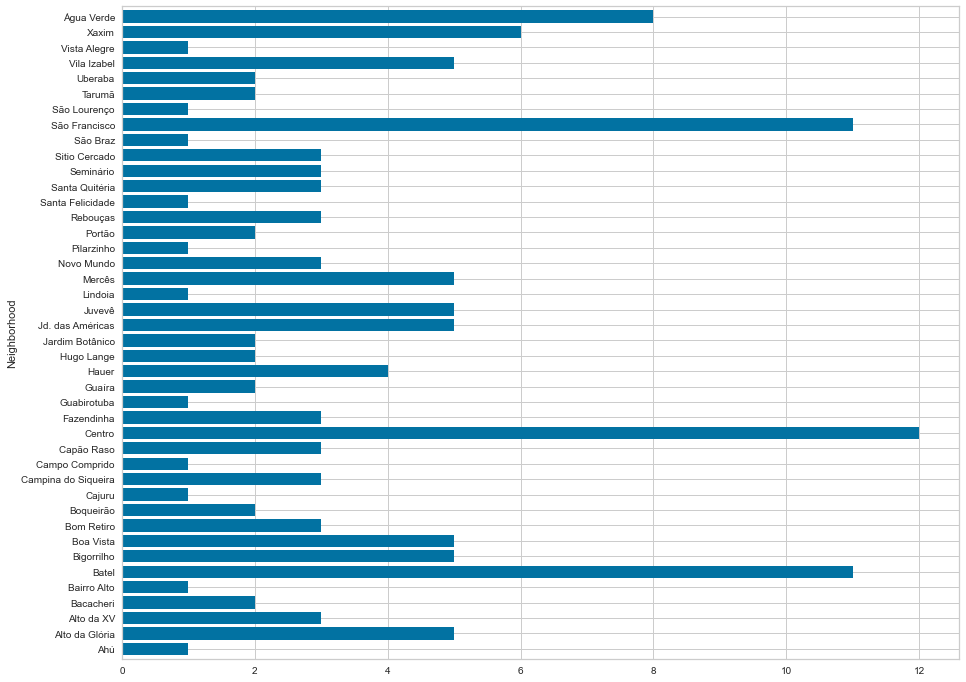

In [19]:
# Plot data

cwb_goodandcheap_rest_count = cwb_goodandcheap_rest.groupby('Neighborhood').count()
cwb_goodandcheap_rest_count['Venue'].plot(kind='barh', figsize=(15, 12), width = 0.8)
plt.show()

And a **heatmap** identify regions with the highest concentration of good and cheap restaurants.

In [59]:
cwb_heatdata_df = pd.DataFrame(columns = ['Venue Latitude','Venue Longitude'])

cwb_goodandcheap_rest_coord = cwb_goodandcheap_rest[['Venue Latitude','Venue Longitude']]
cwb_heatdata_df['Venue Latitude'] = cwb_goodandcheap_rest_coord['Venue Latitude'].astype(float)
cwb_heatdata_df['Venue Longitude'] = cwb_goodandcheap_rest_coord['Venue Longitude'].astype(float)

cwb_heatdata = []
cwb_heatdata = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in cwb_heatdata_df.iterrows()]

In [61]:
from folium.plugins import HeatMap


map_cwb_heatdata = folium.Map(location=[curitiba_df_coord['Latitude'][0], curitiba_df_coord['Longitude'][0]], zoom_start=10)
HeatMap(cwb_heatdata).add_to(map_cwb_heatdata)
map_cwb_heatdata

To finish our analysis per neighborhood, some statistics:

In [65]:
cluster2df_stats = cwb_goodandcheap_rest.groupby('Neighborhood').agg({'Likes':'sum','Tips':'sum','Rating':'mean'})
cluster2df_stats.columns = ['Likes_Sum', 'Tips_Sum', 'Rating_Mean']
cluster2df_stats.sort_values(by='Likes_Sum', ascending=False, inplace=True)
cluster2df_stats

,Likes_Sum,Tips_Sum,Rating_Mean
Neighborhood,,,
Batel,958,227,7.960000
São Francisco,934,269,7.933333
Centro,875,316,8.250000
Água Verde,418,175,8.325000
Alto da Glória,384,159,7.850000
Hugo Lange,306,92,8.400000
Alto da XV,175,59,8.100000
Vila Izabel,169,64,7.900000
Jd. das Américas,143,70,8.060000


### Binning Ratings

To go deeper in our analysis and make our interactive map more usefull, we can split the ratings in Low, Mid and High and plot them with different colors.

Text(0.5, 1.0, 'Rating bins')

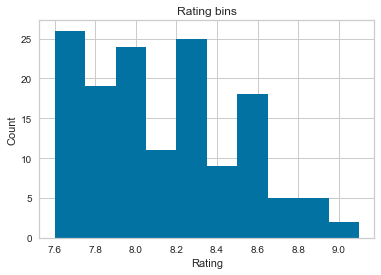

In [20]:
%matplotlib inline
plt.hist(cwb_goodandcheap_rest["Rating"])

# set x/y labels and plot title
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating bins")

We build a bin array, with a minimum value to a maximum value, with bandwidth calculated above. The bins will be values used to determine when one bin ends and another begins.


In [21]:
bins = np.linspace(min(cwb_goodandcheap_rest["Rating"]), max(cwb_goodandcheap_rest["Rating"]), 4)

bins

array([7.6, 8.1, 8.6, 9.1])

 We set group  names:

In [22]:
group_names = ['Low', 'Medium', 'High']

 We apply the function "cut" the determine what each value of "cwb_goodandcheap_rest["Rating"]" belongs to. 

In [ ]:
cwb_goodandcheap_rest["Rating-Binned"] = pd.cut(cwb_goodandcheap_rest["Rating"], bins, labels=group_names, include_lowest=True )
cwb_goodandcheap_rest

We create a function do define colors for eath rating bin:

In [24]:
# Function to set color scheme for ratings
def color(argument):
    switcher = {
        'Low': 'blue',
        'Medium': 'yellow',
        'High': 'red',
    }
    return switcher.get(argument, "nothing")

Finaly, let's **create our interactive map** which can be used as a guide of **good and cheap restaurants in Curitiba**.

In [25]:
map_clusters = folium.Map(location=[curitiba_restaurants['Neighborhood Latitude'][0], curitiba_restaurants['Neighborhood Longitude'][0]], zoom_start=10)

# add markers to map
#markers_colors = []
for lat, lon, ven, rat, rbin in zip(cwb_goodandcheap_rest['Venue Latitude'], cwb_goodandcheap_rest['Venue Longitude'], cwb_goodandcheap_rest['Venue'], cwb_goodandcheap_rest['Rating'], cwb_goodandcheap_rest['Rating-Binned']):   
    label = folium.Popup(str(ven) + ' - Rating ' + str(rat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color(rbin),
        fill=True,
        fill_color=color(rbin),
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters



## Conclusion 

Purpose of this project was to create a Curitiba guide of where to Eat for Cheap. During the analysis, several important
statistical features of the boroughs and the restaurants were explored and visualized. Furthermore, clustering helped to idenitidy and highlight the group of restaurants we are looking for, and with the Heatmap and some statistics we have identified the region between the three neighborhoods of Centro, Batel and São Francisco as being of greatest interest for our goal. To refine our proposal, we have identified the possibility to rank the restaurants from this cluster based on their rating, to finally create the interactive map, our final objective.


